In [1]:
# %%bash
# !pip install --quiet langchain-community 
# pip install --quiet langchain-experimental langchain-openai 
# pip install graphdatascience tiktoken retry neo4j

In [2]:
import os
import pandas as pd
import tiktoken
from langchain_community.graphs import Neo4jGraph
import tqdm

pd.set_option('display.max_colwidth', None)

In [3]:
os.environ["NEO4J_URI"] = "neo4j+s://42ad883e.databases.neo4j.io"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "1aQKHazCtNgLPe_35mQohHVZZYsCiGj5-LwqdemSS5E"
graph = Neo4jGraph()

In [14]:
data = pd.read_csv("IPL_Match_Highlights_Commentary.csv")
data = data.sample(5)

In [15]:
data.count()

Match_id      100
Team          100
Over_num      100
Commentary    100
batsman       100
score         100
dtype: int64

In [16]:
def get_token_count(text, model='gpt-4o'):
    encoding = tiktoken.encoding_for_model(model)
    num_tokens = len(encoding.encode(text))
    return num_tokens
data['token_count'] = [get_token_count(f"{row['Team']} {row['Commentary']}") for i, row in data.iterrows()]

<Axes: title={'center': 'Token Count Distribution'}, xlabel='Token Count', ylabel='Frequency'>

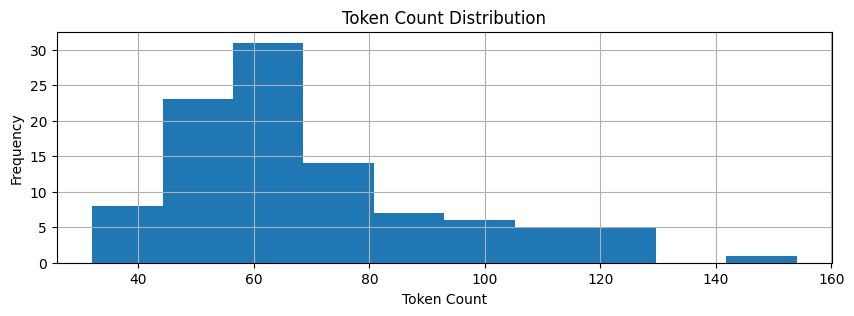

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.title("Token Count Distribution")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
data['token_count'].hist()

In [18]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_community.graphs.graph_document import GraphDocument
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_openai import AzureChatOpenAI

os.environ["AZURE_OPENAI_API_KEY"] = "533894d8f28d4f238f10c0a51a46789e"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://sriks-openai.openai.azure.com/"
os.environ["AZURE_OPENAI_API_VERSION"] = "2024-05-01-preview"
os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT"] = "gpt-4o"

llm = AzureChatOpenAI(
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    azure_deployment=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT"],
)

llm_transformer = LLMGraphTransformer(
    llm=llm,
    node_properties=["description"],
    relationship_properties=["description"]
)     

In [19]:
graph_documents = []
for i, row in tqdm.tqdm(data.iterrows()):
    text = f"{row['Team']} {row['Commentary']}"
    graph_document = Document(page_content=text)
    transformed_graph_document = llm_transformer.convert_to_graph_documents([graph_document])
    graph_documents.extend(transformed_graph_document)


25it [03:21,  8.07s/it]


KeyboardInterrupt: 

In [ ]:
graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)